In [1]:
import os
import numpy as np
import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
from dti_util import code_dam, decode_dam
# Change default matplotlib
mpl.rcParams['savefig.dpi']=150
mpl.rcParams['savefig.bbox']='tight'
mpl.rcParams['savefig.pad_inches']=0.1
mpl.rcParams['axes.labelsize']=mpl.rcParams['axes.titlesize']

In [2]:
#datadir = '/Data/sim/antonk/shom5km_defor_4cnn'
rootdir = '/mnt/sfe-ns9602k/Julien/data'
datadir = os.path.join(rootdir,'anton/shom5km_defor_4cnn')
traindir = os.path.join(rootdir,'train')

In [49]:
lfiles=list(map(os.path.basename,sorted(glob.glob(os.path.join(datadir,'field*.npz')))))
n = len(lfiles)
print(f'{n} files found')

529 files found


In [14]:
#Load the first file to set the dimensions
sample0 = np.load(os.path.join(datadir,lfiles[0]))
dam0 = sample0['d']
ny, nx = dam0.shape


In [15]:
epsi=1e-2
colnames = ('deformation_0',)
othernames = ('h',)


# Thresholds
th_sit = 0.9 # Sea ice concentration
th_dam = 0.8 # Damage

In [16]:
norm = lambda x : code_dam(x,epsi=epsi, vmin=th_dam)
denorm = lambda x : decode_dam(x,epsi=epsi, vmin=th_dam)

In [17]:
# Create dataset

allcols = colnames+othernames
nc = len(colnames) #number of channel
no = len(othernames) #other data used for masking, diag but not in input
Xall = np.empty((n,ny,nx,nc+no))
target = np.empty((n,ny,nx,1))
for i in tqdm(range(n)):
    sample = np.load(os.path.join(datadir,lfiles[i]))
    target[i,:,:,0] = norm(sample['d'])
    for ic,c in enumerate(allcols):
        if c == 'deformation_0':
            xx = np.log10(24 * 60 * 60 * np.hypot(sample['e1_0'], sample['e2_0']))
            #24*60*60 to convert fom s-1 to d-1
            #xx[~np.isfinite(xx)]=0
        else:
            xx = sample[c]
        Xall[i,:,:,ic] = xx
            
X = Xall[...,:nc]
target = target
Xother = Xall[...,nc:]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


In [8]:
target.shape

(529, 400, 500, 1)

In [27]:
# Mask 



# Create the numerical value mask
mask_num = np.all( (np.isfinite(Xall)) & (np.isfinite(target)),axis=3)[...,np.newaxis]


# Create the sit mask
ih = othernames.index('h') # Index of the sea ice concentration field
mask_sit = Xother[...,ih:ih+1]> th_sit

# Create the damage mask
mask_dam = denorm(target) > th_dam

mask_num.shape, mask_sit.shape, mask_dam.shape
mask_all = mask_num & mask_sit & mask_dam
mask_in = mask_num

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  


In [31]:
# Plot to check
iplot = [0,10,100,400]
xx = X[iplot,...,0]
yy0 = target[iplot,...,0]
ww = mask_all[iplot,...,0]

xx[~mask_in[iplot,...,0]]= np.nan
yy0[~ww] = np.nan


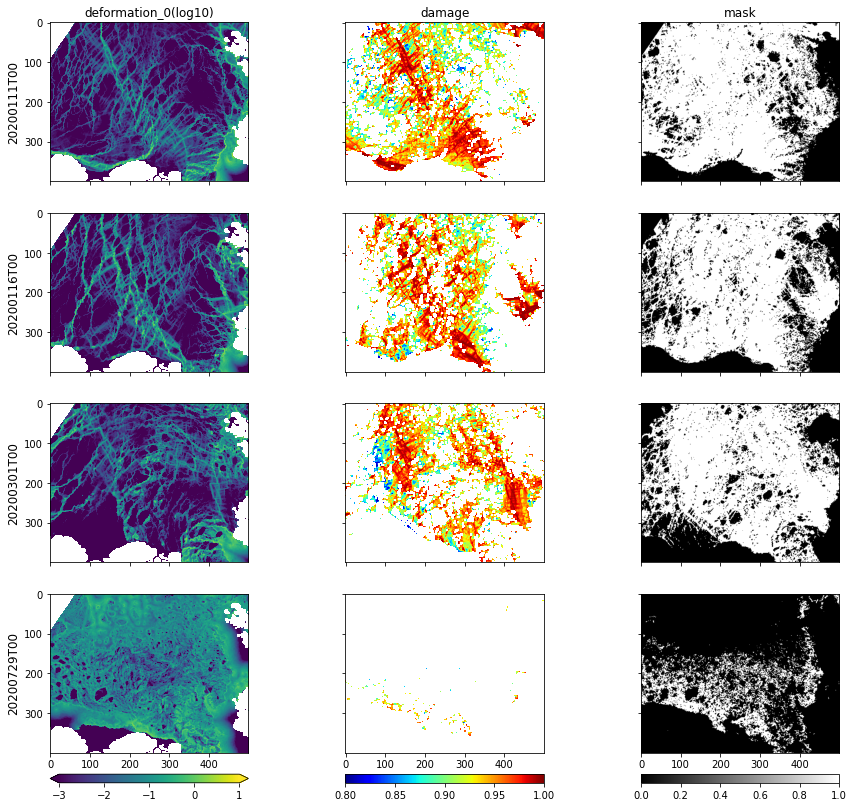

In [33]:
#fig = plt.figure(figsize=(15,3*len(iplot)))
fig, ax = plt.subplots(nrows=len(iplot), ncols=3,sharex='all', sharey='all', figsize=(15,3*len(iplot)))
fig.subplots_adjust(bottom=0.035)
c = dict()
for iy in range(len(iplot)):
    c[0] = ax[iy,0].imshow(xx[iy],vmin=-3, vmax=1)
    c[1] = ax[iy,1].imshow(denorm(yy0[iy]), vmin=th_dam,vmax=1.,cmap='jet')
    c[2] = ax[iy,2].imshow(ww[iy],cmap='gray', vmin=0, vmax=1)
    ax[iy,0].set_ylabel(lfiles[iplot[iy]][6:17])
ax[0,0].set_title(colnames[0]+'(log10)');
ax[0,1].set_title('damage');
ax[0,2].set_title('mask');
cbar_ax = dict()
lextend = ['both','neither','neither']
for i in range(3):
    pos = ax[3,i].get_position()
    left = pos.extents[0]
    width = pos.extents[2] - pos.extents[0]
    cbar_ax[i] = fig.add_axes([left, 0., width, 0.01])
    fig.colorbar(c[i], cax=cbar_ax[i], orientation='horizontal', extend=lextend[i])




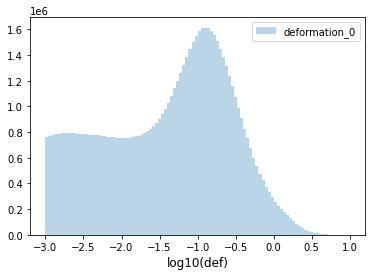

In [37]:
bins = 100

lims = [-3, 1]
plt.hist(X[mask_in].ravel(), bins,  lims, alpha=0.3, label='deformation_0')
plt.xlabel('log10(def)')
plt.legend()
plt.savefig('figs/histo_def0.png')

In [38]:

dd_test = np.linspace(0,1,100)
dd_equal = denorm(norm(dd_test))

np.testing.assert_almost_equal(dd_test,dd_equal)

Text(0.5, 0, 'Damage (coded)')

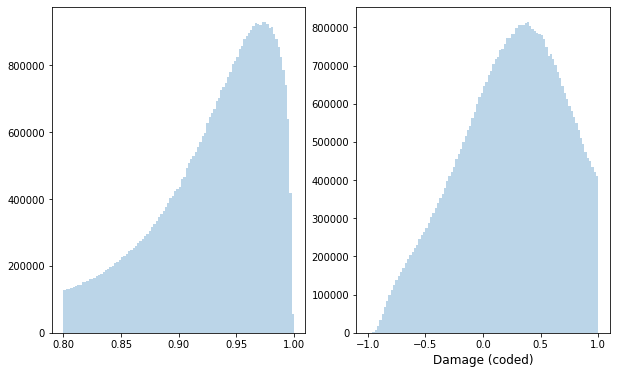

In [39]:
bins = 100

fig,ax = plt.subplots(ncols=2,figsize=(10,6))

dd = target[mask_all].ravel()
lims = [norm(1),norm(th_dam)]

ax[0].hist(denorm(dd),bins,(th_dam, 1), alpha=0.3)
ax[1].hist(dd, bins,  lims, alpha=0.3, label='Damage (coded)')
ax[1].set_xlabel('Damage (coded)')


In [40]:


def im2tile(X2,y2, dsize=25,slic=1):
    nn,ny,nx,nc = X2.shape
    print(nn,ny,nx,nc)
    nrows = (ny-dsize)//slic + 1
    ncols = (nx-dsize)//slic +1
    print(nrows,ncols)

    X1 = np.empty((nrows*ncols*nn,dsize,dsize,nc))
    y1 = np.zeros((nrows*ncols*nn,y2.shape[-1]))
    print (X1.shape)
    k=0
    for im in range(nn):
        for ix in range(ncols):
            for iy in range(nrows):
                X1[k,:,:,:] = X2[im,iy*slic:iy*slic+dsize,ix*slic:ix*slic+dsize,:]
                y1[k,:] = y2[im,iy*slic+dsize//2,ix*slic+dsize//2,:]
                k=k+1
    return X1,y1

def tile2im(X1,y1,slic=1,ny=400,nx=500):
    dsize = X1.shape[1]
    nrows = (ny-dsize)//slic + 1
    ncols = (nx-dsize)//slic +1
    nn = X1.shape[0]//(nrows*ncols)
    nc = X1.shape[-1]
    X2 = np.empty((nn,ny,nx,nc))
    y2 = np.zeros((nn,ny,nx,2))
    print(nn,nrows,ncols)
    k=0
    for im in range(nn):
        for ix in range(ncols):
            for iy in range(nrows):
                X2[im,iy*slic:iy*slic+dsize,ix*slic:ix*slic+dsize,:]=X1[k,:,:,:]
                y2[im,iy*slic+dsize//2,ix*slic+dsize//2,:]=y1[k,:]
                k=k+1
    return X2, y2

In [41]:
# Transform big images to smaller ones for training
nimtrain = 410
mimstart = 10
mask_in2 = mask_in[mimstart:mimstart+nimtrain]
mask_all2 = mask_all[mimstart:mimstart+nimtrain]
X2 = X[mimstart:mimstart+nimtrain]
y2 = target[mimstart:mimstart+nimtrain]
X2[~mask_in2]=np.nan
y2[~mask_all2]=np.nan

X1, y1 = im2tile(X2,y2, slic=20)
X2r, y2r, = tile2im(X1,y1, slic= 20)
nn,ny,nx,nc = X2.shape
X1.shape, y1.shape, y2.shape

410 400 500 1
19 24
(186960, 25, 25, 1)
410 19 24


((186960, 25, 25, 1), (186960, 1), (410, 400, 500, 1))

In [42]:
mask_train_in =  np.all(np.isfinite(X1),axis=(1,2,3)) 
print(mask_train_in.sum())
mask_train_out =  np.all(np.isfinite(y1),axis=(1)) 
print(mask_train_out.sum())
mask_train = mask_train_in & mask_train_out
print(mask_train.sum())

162770
111946
105957


In [43]:
print(mask_train.shape,mask_train.sum())
Xtrain = X1[mask_train,:]
ytrain = y1[mask_train,0]
print(Xtrain.shape, ytrain.shape)
np.savez(os.path.join(traindir,'train.npz'),Xtrain=Xtrain, ytrain=ytrain, mask_train=mask_train, shape_original=(nn,ny,nx))

(186960,) 105957
(105957, 25, 25, 1) (105957,)


In [46]:
# Test image
itest = 0
mask_in2 = mask_in[itest:itest+1]
mask_all2 = mask_all[itest:itest+1]
X2 = X[itest:itest+1]
y2 = target[itest:itest+1]
X2[~mask_in2]=np.nan
y2[~mask_in2]=np.nan

X1, y1 = im2tile(X2,y2, slic=1)
X2r, y2r, = tile2im(X1,y1, slic= 1)
nn,ny,nx,nc = X2.shape
X1.shape, y1.shape, y2.shape

1 400 500 1
376 476
(178976, 25, 25, 1)
1 376 476


((178976, 25, 25, 1), (178976, 1), (1, 400, 500, 1))

In [47]:
mask_train_in =  np.all(np.isfinite(X1),axis=(1,2,3)) 
print(mask_train_in.sum())
mask_train_out =  np.all(np.isfinite(y1),axis=(1)) 
print(mask_train_out.sum())
mask_train = mask_train_in & mask_train_out
print(mask_train.sum())

154300
168563
154300


In [48]:
print(mask_train.shape,mask_train.sum())
Xtrain = X1[mask_train,:]
ytrain = y1[mask_train,0]
print(Xtrain.shape, ytrain.shape)
np.savez(os.path.join(traindir,'test.npz'),Xtrain=Xtrain, ytrain=ytrain, mask_train=mask_train, shape_original=(nn,ny,nx))

(178976,) 154300
(154300, 25, 25, 1) (154300,)


In [15]:
def test_custom_loss(dummy, XX, yy):
    """Test if the Keras model has a cost of zeros over the masked pixels
    """
    mask = yy[...,1:]==0
    weights = yy[...,1:]>0
    eval1 = dummy.evaluate(XX, yy, batch_size=20)
    yy_bis = yy.copy()
    yy_bis[...,0][mask[...,0]] = 2
    plt.imshow(yy_bis[10,...,0]-yy[10,...,0])
    plt.show()
    diff1 = np.linalg.norm(yy_bis[...,0]-yy[...,0])
    eval2 = dummy.evaluate(XX, yy_bis, batch_size=20)
    yy_bis = yy.copy()
    yy_bis[...,0][weights[...,0].astype('bool')] = 2
    plt.imshow(yy_bis[10,...,0]-yy[10,...,0])
    plt.show()
    diff2 = np.linalg.norm(yy_bis[...,0]-yy[...,0])
    eval3 = dummy.evaluate(XX, yy_bis, batch_size=20)

    assert diff1>0
    assert eval1 == eval2
    assert diff2 >2
    assert eval1 != eval3
    return 0

In [ ]:
test_custom_loss(dummy, X[:20],target_weighted[:20])
